# Summary of Dataset Analysis and Model Selection  

## Dataset Analysis  

The dataset was carefully studied and found to be **highly structured**, with **subtle variations** distinguishing different classes. Due to the minimal differences between classes, **augmentation** was essential to enhance model generalization. Based on the dataset’s properties, the following augmentation techniques were selected:  

- **Horizontal Flip & Vertical Flip** – To leverage position invariance.  
- **180° Rotation** – To enhance robustness to orientation changes.  
- **Slight Rotations (±10°)** – To introduce minor distortions while preserving meaningful structures.  

## Model Testing and Selection  

Several architectures were tested to identify the most suitable model for this structured dataset:  

- **EfficientNet**  
- **RegNet**  
- **DeiT (Data-efficient Image Transformer)**  
- **MobileViT**  

### Observations  

The dataset was observed to perform **better on attention-based models** (such as DeiT and MobileViT), likely due to:  

- **High structural consistency** across images.  
- **Subtle differences** between classes requiring fine-grained feature extraction.  

### Final Model Choice  

After extensive testing, a **modified version of MobileViT-XS** was selected as the optimal model, mostly due to computation speed. This architecture was adapted from the implementation found [here](https://github.com/chinhsuanwu/mobilevit-pytorch).  

### Key Modifications & Findings  

- A **patch size of 2** was found to work best, preserving spatial details while ensuring effective tokenization.  
- Training was **highly sensitive to learning rate**, necessitating careful tuning through experimental trials to determine the most stable and effective value.  



In [1]:
!gdown --fuzzy https://drive.google.com/file/d/1-7hefAxtTTpukKJtW_UFcxafcLljIDr8/view?usp=sharing
!unzip Dataset3.zip > /dev/null

Downloading...
From (original): https://drive.google.com/uc?id=1-7hefAxtTTpukKJtW_UFcxafcLljIDr8
From (redirected): https://drive.google.com/uc?id=1-7hefAxtTTpukKJtW_UFcxafcLljIDr8&confirm=t&uuid=884aaeba-4806-40ca-95b9-9924af111fa9
To: /kaggle/working/Dataset3.zip
100%|██████████████████████████████████████| 1.13G/1.13G [00:18<00:00, 60.6MB/s]


Import Libraries

In [2]:
import os
import torch
import random
import numpy as np
from tqdm import tqdm
import torch.nn as nn
from einops import rearrange
import matplotlib.pyplot as plt

import albumentations as A
import albumentations.pytorch as AP

from torchvision import transforms
from torchvision import datasets as dsets
from torch.utils.data import DataLoader


import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import roc_auc_score

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


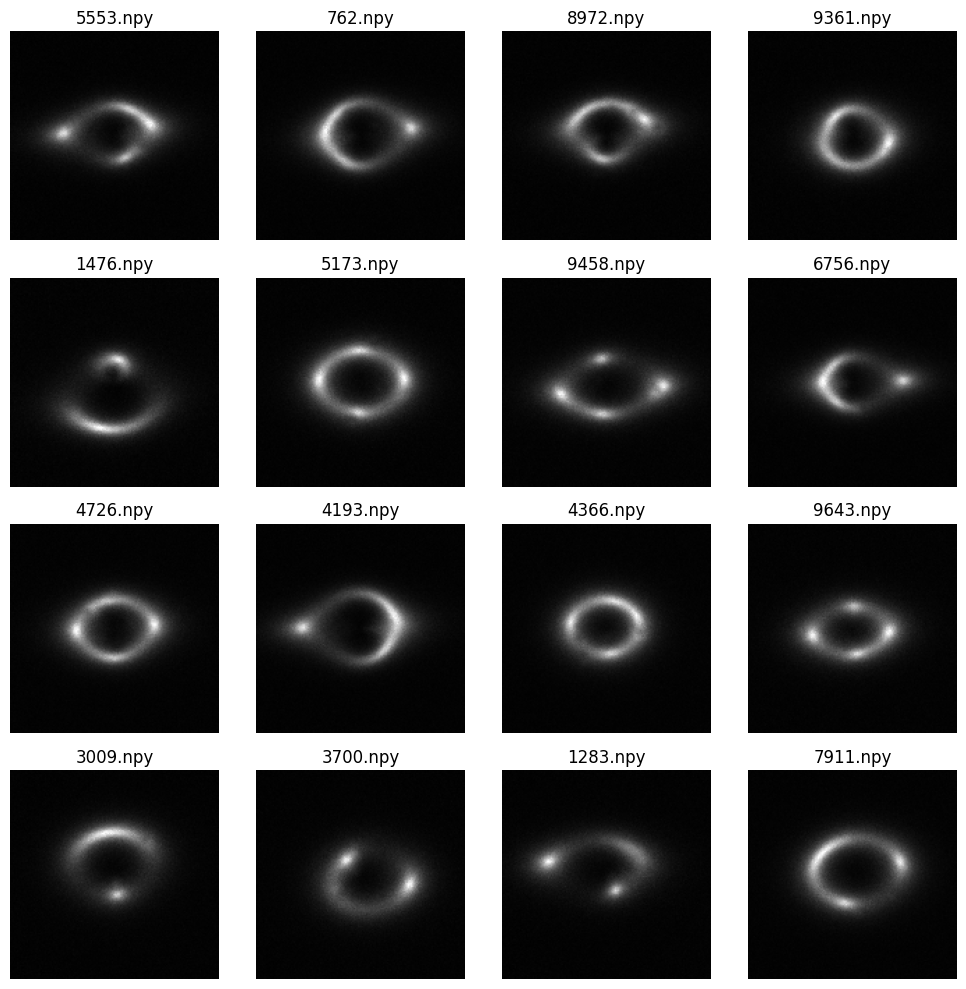

Sphere Substructure


In [3]:
# Path to dataset
dataset_path = "/kaggle/working/dataset/train/sphere"

# List all .npy files in the directory
all_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith(".npy")]

# Select 16 random images
random_files = random.sample(all_files, 16)

# Set up the plot
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

# Loop through selected files and display images
for ax, file_path in zip(axes.flatten(), random_files):
    image_data = np.load(file_path)
    image_tensor = torch.from_numpy(image_data)
    image_data = image_tensor.numpy().squeeze()  # Convert back to NumPy and remove unnecessary dimensions

    # Ensure valid image dimensions
    if len(image_data.shape) not in (2, 3):
        raise ValueError(f"Invalid image shape: {image_data.shape}. Expected 2D (grayscale) or 3D (RGB) array.")

    ax.imshow(image_data, cmap="gray" if len(image_data.shape) == 2 else None)
    ax.set_title(os.path.basename(file_path))
    ax.axis("off")

# Adjust layout and show plot
plt.tight_layout()
plt.show()
print('Sphere Substructure')

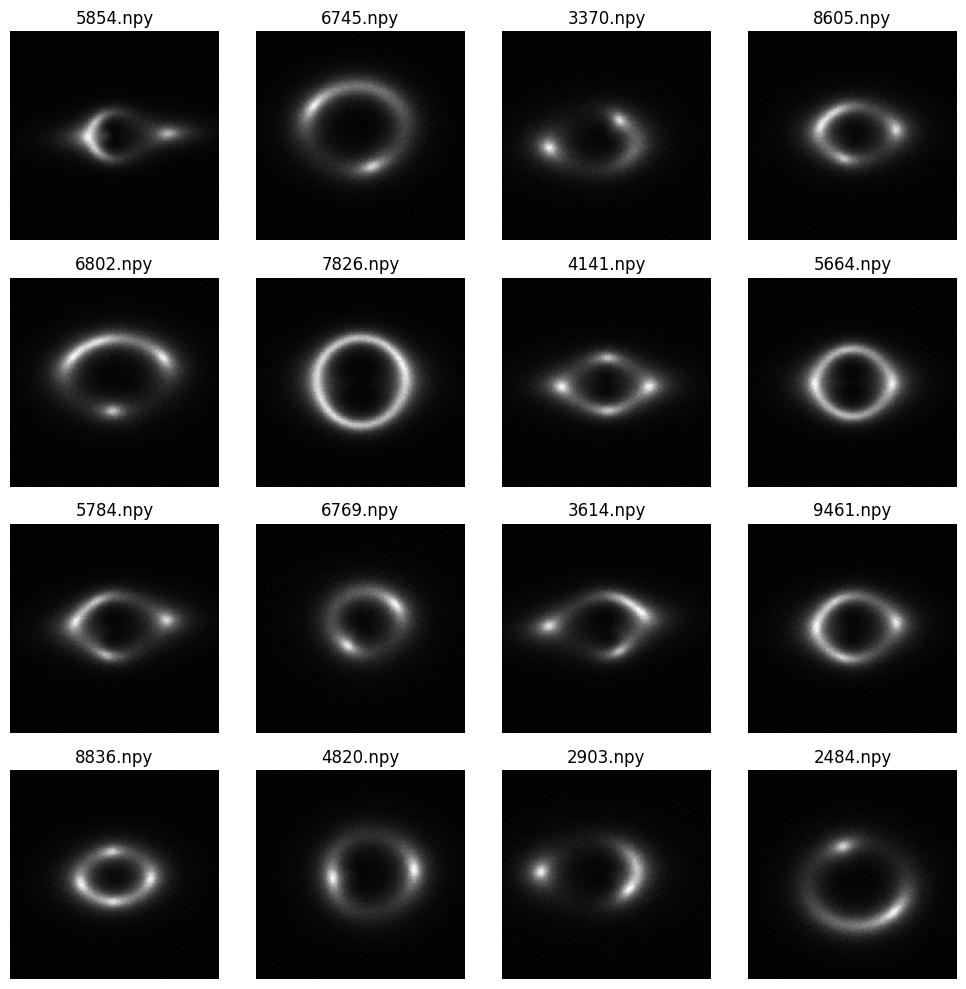

No Substructure


In [4]:
# Path to dataset
dataset_path = "/kaggle/working/dataset/train/no"

# List all .npy files in the directory
all_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith(".npy")]

# Select 16 random images
random_files = random.sample(all_files, 16)

# Set up the plot
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

# Loop through selected files and display images
for ax, file_path in zip(axes.flatten(), random_files):
    image_data = np.load(file_path)
    image_tensor = torch.from_numpy(image_data)
    image_data = image_tensor.numpy().squeeze()  # Convert back to NumPy and remove unnecessary dimensions

    # Ensure valid image dimensions
    if len(image_data.shape) not in (2, 3):
        raise ValueError(f"Invalid image shape: {image_data.shape}. Expected 2D (grayscale) or 3D (RGB) array.")

    ax.imshow(image_data, cmap="gray" if len(image_data.shape) == 2 else None)
    ax.set_title(os.path.basename(file_path))
    ax.axis("off")

# Adjust layout and show plot
plt.tight_layout()
plt.show()
print('No Substructure')

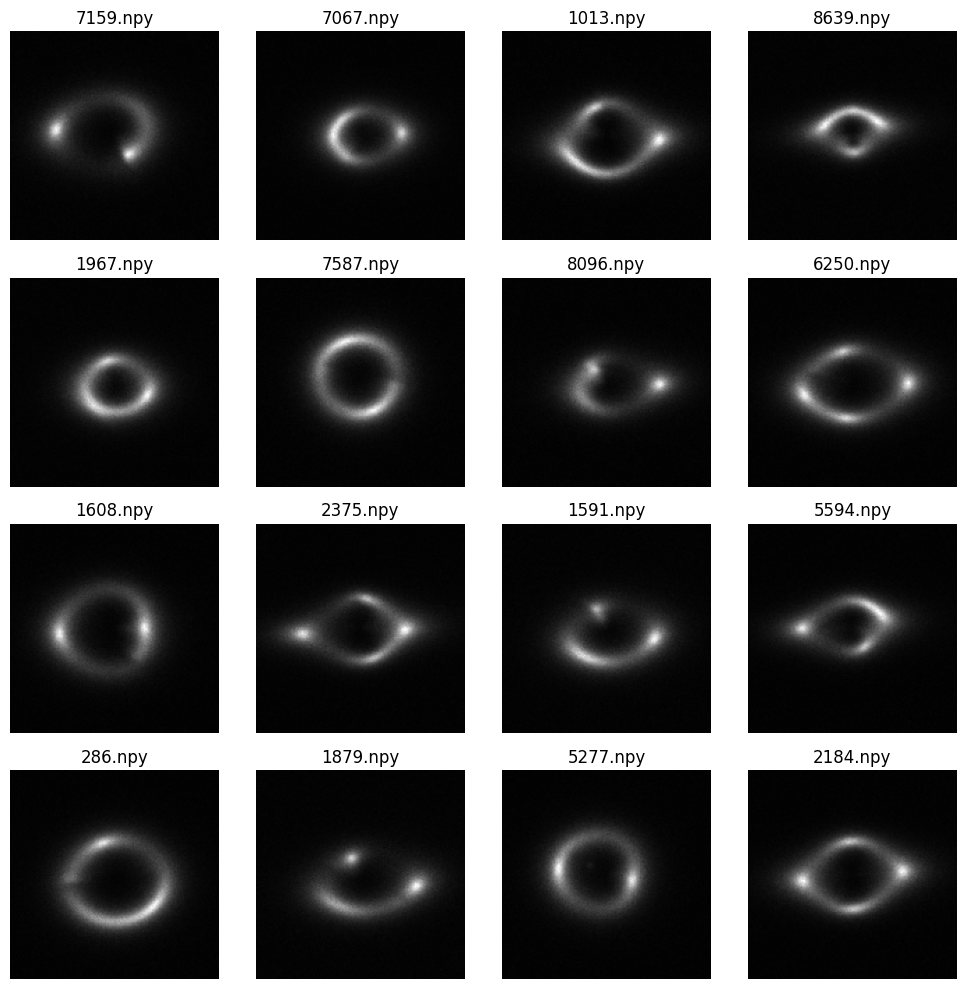

Vortex Substructure


In [5]:
# Path to dataset
dataset_path = "/kaggle/working/dataset/train/vort"

# List all .npy files in the directory
all_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith(".npy")]

# Select 16 random images
random_files = random.sample(all_files, 16)

# Set up the plot
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

# Loop through selected files and display images
for ax, file_path in zip(axes.flatten(), random_files):
    image_data = np.load(file_path)
    image_tensor = torch.from_numpy(image_data)
    image_data = image_tensor.numpy().squeeze()  # Convert back to NumPy and remove unnecessary dimensions

    # Ensure valid image dimensions
    if len(image_data.shape) not in (2, 3):
        raise ValueError(f"Invalid image shape: {image_data.shape}. Expected 2D (grayscale) or 3D (RGB) array.")

    ax.imshow(image_data, cmap="gray" if len(image_data.shape) == 2 else None)
    ax.set_title(os.path.basename(file_path))
    ax.axis("off")

# Adjust layout and show plot
plt.tight_layout()
plt.show()
print('Vortex Substructure')

In [ ]:
def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.SiLU()
    )


def conv_nxn_bn(inp, oup, kernal_size=3, stride=1):
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernal_size, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.SiLU()
    )


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b p n (h d) -> b p h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attn = self.attend(dots)
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b p h n d -> b p n (h d)')
        return self.to_out(out)


class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads, dim_head, dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout))
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x


class MV2Block(nn.Module):
    def __init__(self, inp, oup, stride=1, expansion=4):
        super().__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = int(inp * expansion)
        self.use_res_connect = self.stride == 1 and inp == oup

        if expansion == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileViTBlock(nn.Module):
    def __init__(self, dim, depth, channel, kernel_size, patch_size, mlp_dim, dropout=0.):
        super().__init__()
        self.ph, self.pw = patch_size

        self.conv1 = conv_nxn_bn(channel, channel, kernel_size)
        self.conv2 = conv_1x1_bn(channel, dim)

        self.transformer = Transformer(dim, depth, 4, 8, mlp_dim, dropout)

        self.conv3 = conv_1x1_bn(dim, channel)
        self.conv4 = conv_nxn_bn(2 * channel, channel, kernel_size)

    def forward(self, x):
        y = x.clone()

        # Local representations
        x = self.conv1(x)
        x = self.conv2(x)

        # Global representations
        _, _, h, w = x.shape
        x = rearrange(x, 'b d (h ph) (w pw) -> b (ph pw) (h w) d', ph=self.ph, pw=self.pw)
        x = self.transformer(x)
        x = rearrange(x, 'b (ph pw) (h w) d -> b d (h ph) (w pw)', h=h//self.ph, w=w//self.pw, ph=self.ph, pw=self.pw)

        # Fusion
        x = self.conv3(x)
        x = torch.cat((x, y), 1)
        x = self.conv4(x)
        return x


class MobileViT(nn.Module):
    def __init__(self, image_size, dims, channels, num_classes, expansion=4, kernel_size=3, patch_size=(2, 2)):
        super().__init__()
        ih, iw = image_size
        ph, pw = patch_size
        assert ih % ph == 0 and iw % pw == 0

        L = [2, 4, 3]

        self.conv1 = conv_nxn_bn(1, channels[0], stride=2)

        self.mv2 = nn.ModuleList([])
        self.mv2.append(MV2Block(channels[0], channels[1], 1, expansion))
        self.mv2.append(MV2Block(channels[1], channels[2], 2, expansion))
        self.mv2.append(MV2Block(channels[2], channels[3], 1, expansion))
        self.mv2.append(MV2Block(channels[2], channels[3], 1, expansion))   # Repeat
        self.mv2.append(MV2Block(channels[3], channels[4], 2, expansion))
        self.mv2.append(MV2Block(channels[5], channels[6], 2, expansion))
        self.mv2.append(MV2Block(channels[7], channels[8], 2, expansion))

        self.mvit = nn.ModuleList([])
        self.mvit.append(MobileViTBlock(dims[0], L[0], channels[5], kernel_size, patch_size, int(dims[0]*2)))
        self.mvit.append(MobileViTBlock(dims[1], L[1], channels[7], kernel_size, patch_size, int(dims[1]*4)))
        self.mvit.append(MobileViTBlock(dims[2], L[2], channels[9], kernel_size, patch_size, int(dims[2]*4)))

        self.conv2 = conv_1x1_bn(channels[-2], channels[-1])

        self.pool = nn.AvgPool2d(ih//32, 1)
        self.fc = nn.Linear(channels[-1], num_classes, bias=False)

    def forward(self, x):
        x = self.conv1(x)
        x = self.mv2[0](x)

        x = self.mv2[1](x)
        x = self.mv2[2](x)
        x = self.mv2[3](x)      # Repeat

        x = self.mv2[4](x)
        x = self.mvit[0](x)

        x = self.mv2[5](x)
        x = self.mvit[1](x)

        x = self.mv2[6](x)
        x = self.mvit[2](x)
        x = self.conv2(x)

        x = self.pool(x).view(-1, x.shape[1])
        x = self.fc(x)
        return x


def mobilevit():
    dims = [64, 80, 96]
    channels = [16, 16, 24, 24, 48, 48, 64, 64, 80, 80, 320]
    return MobileViT((128, 128), dims, channels, num_classes=3, expansion=2)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Testing
if __name__ == '__main__':
    img = torch.randn(11, 1, 128, 128)

    model = mobilevit()
    out = model(img)
    print(out.shape)
    print(count_parameters(model))


torch.Size([11, 3])
1012144


In [7]:
# count model parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 1,012,144 trainable parameters


In [8]:
current_directory = os.getcwd()
print(current_directory)

/kaggle/working


In [9]:
def npy_loader(path):
    sample = torch.from_numpy(np.load(path))
    return sample

train_data = dsets.DatasetFolder(
    root=current_directory+'/dataset/train',
    loader=npy_loader,
    extensions=['.npy'],
    #transform=transform
)
test_data = dsets.DatasetFolder(
    root=current_directory+'/dataset/val',
    loader=npy_loader,
    extensions=['.npy'],
    #transform=transform
)

train_data_len = len(train_data)
test_data_len = len(test_data)

batch_size = 32

train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          shuffle=True, drop_last=True)

test_loader = DataLoader(test_data,
                         batch_size=batch_size,
                         shuffle=True, drop_last=True)


In [ ]:
def compute_mean_std(dataloader):
    """Computes the mean and standard deviation of a dataset given a DataLoader."""
    mean = 0.0
    std = 0.0
    total_samples = 0

    for images in tqdm(dataloader):
        if isinstance(images, (list, tuple)):  # If dataset returns (image, label)
            images = images[0]

        batch_samples = images.size(0)  # Batch size (N)
        images = images.view(batch_samples, images.shape[1], -1)  # Flatten spatial dimensions
        mean += images.mean(dim=[0, 2])  # Mean per channel
        std += images.std(dim=[0, 2])  # Std per channel
        total_samples += batch_samples

    mean /= len(dataloader)
    std /= len(dataloader)

    return mean, std


mean, std = compute_mean_std(test_loader)

print(f"Mean: {mean}")
print(f"Std: {std}")


100%|██████████| 234/234 [00:02<00:00, 87.97it/s]

Mean: tensor([0.0617], dtype=torch.float64)
Std: tensor([0.1174], dtype=torch.float64)


In [ ]:
# Define Albumentations transform
transform = A.Compose([
    A.HorizontalFlip(p=0.5),  # Random Horizontal Flip
    A.VerticalFlip(p=0.5),  # Random Vertical Flip
    A.Resize(height=128, width=128, p=1.0),  # Resize
    A.OneOf([
        A.Rotate(limit=[180, 180], p=0.5),  # Strict 180° rotation
        A.Rotate(limit=10, p=0.5)  # Random ±10° rotation
    ], p=1.0),  # Ensures one of the rotations is applied
    #A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),  # Elastic deformation
    A.ToFloat(max_value=1.0),
    A.Normalize(mean=mean, std=std, max_pixel_value=1.0),  # Standardization for grayscale images in [0,1]
    AP.ToTensorV2()  # Convert to PyTorch tensor
])

# Define Albumentations transform
val_transform = A.Compose([
    A.ToFloat(max_value=1.0),
    A.Resize(height=128, width=128, p=1.0),  # Resize 
    A.Normalize(mean=mean, std=std, max_pixel_value=1.0),  # Standardization for grayscale images in [0,1]
    AP.ToTensorV2()  # Convert to PyTorch tensor
])

def npy_loader(path):
    """Loads an .npy image, applies Albumentations, and converts it to a PyTorch tensor."""
    image = np.load(path)  # Load .npy file

    # Apply Albumentations transform
    image = np.transpose(image, (1, 2, 0))  # (H, W, C)
    augmented = transform(image=image)
    return augmented["image"] # Returns PyTorch tensor
    #return torch.from_numpy(augmented["image"])  # Returns PyTorch tensor

def val_npy_loader(path):
    """Loads an .npy image, applies Albumentations, and converts it to a PyTorch tensor."""
    image = np.load(path)  # Load .npy file

    # Apply Albumentations transform
    image = np.transpose(image, (1, 2, 0))  # (H, W, C)
    augmented = val_transform(image=image)
    return augmented["image"] # Returns PyTorch tensor
    #return torch.from_numpy(augmented["image"])  # Returns PyTorch tensor


train_data = dsets.DatasetFolder(
    root=current_directory+'/dataset/train',
    loader=npy_loader,
    extensions=['.npy'],
    #transform=AlbumentationsTransformWrapper(transform)
)
test_data = dsets.DatasetFolder(
    root=current_directory+'/dataset/val',
    loader=val_npy_loader,
    extensions=['.npy'],
    #transform=AlbumentationsTransformWrapper(transform)
)

train_data_len = len(train_data)
test_data_len = len(test_data)

batch_size = 32

train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          shuffle=True, drop_last=True)

test_loader = DataLoader(test_data,
                         batch_size=batch_size,
                         shuffle=True, drop_last=True)


In [12]:
def train_one_epoch(model, train_dataloader, optimizer, device):
    model.train()
    total_loss, correct, total_samples = 0.0, 0, 0

    for images, labels in tqdm(train_dataloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

    avg_loss = total_loss / total_samples
    accuracy = correct / total_samples
    return avg_loss, accuracy

def validate(model, val_dataloader, device):
    model.eval()
    total_loss, correct, total_samples = 0.0, 0, 0
    all_labels, all_probs = [], []

    with torch.no_grad():
        for images, labels in tqdm(val_dataloader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)

            total_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(F.softmax(outputs, dim=1).cpu().numpy())

    avg_loss = total_loss / total_samples
    accuracy = correct / total_samples

    # Compute 3-class ROC AUC score
    try:
        auc_score = roc_auc_score(all_labels, all_probs, multi_class='ovr')
    except:
        auc_score = 0.0  # Handle case where AUC computation fails

    return avg_loss, accuracy, auc_score

In [13]:
def train_model(model, train_dataloader, val_dataloader, optimizer, num_epochs=30, device="cuda"):
    model.to(device)
    #scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
    best_auc = 0.0
    best_model_path = "best_test1_model.pth"

    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, train_dataloader, optimizer, device)
        val_loss, val_acc, val_auc = validate(model, val_dataloader, device)
        #scheduler.step()

        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f}")

        # Save model if AUC improves
        if val_auc > best_auc:
            best_auc = val_auc
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved with AUC: {best_auc:.4f}")

    print("Training complete. Best AUC:", best_auc)

In [14]:
# Initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

# Train the model
train_model(model, train_loader, test_loader, optimizer, num_epochs=40, device="cuda")

100%|██████████| 234/234 [00:07<00:00, 31.14it/s]


Epoch 1/40: Train Loss: 1.1018, Train Acc: 0.3370 | Val Loss: 1.0999, Val Acc: 0.3392, Val AUC: 0.5133
New best model saved with AUC: 0.5133


100%|██████████| 234/234 [00:07<00:00, 31.59it/s]


Epoch 2/40: Train Loss: 1.0987, Train Acc: 0.3507 | Val Loss: 1.0985, Val Acc: 0.3519, Val AUC: 0.5179
New best model saved with AUC: 0.5179


100%|██████████| 234/234 [00:07<00:00, 32.06it/s]


Epoch 3/40: Train Loss: 1.0964, Train Acc: 0.3586 | Val Loss: 1.0923, Val Acc: 0.3634, Val AUC: 0.5507
New best model saved with AUC: 0.5507


100%|██████████| 234/234 [00:07<00:00, 32.64it/s]


Epoch 4/40: Train Loss: 1.0469, Train Acc: 0.4233 | Val Loss: 0.9955, Val Acc: 0.4889, Val AUC: 0.6982
New best model saved with AUC: 0.6982


100%|██████████| 234/234 [00:07<00:00, 31.49it/s]


Epoch 5/40: Train Loss: 0.8818, Train Acc: 0.5673 | Val Loss: 0.8067, Val Acc: 0.6131, Val AUC: 0.8033
New best model saved with AUC: 0.8033


100%|██████████| 234/234 [00:07<00:00, 30.77it/s]


Epoch 6/40: Train Loss: 0.7533, Train Acc: 0.6529 | Val Loss: 0.6866, Val Acc: 0.6926, Val AUC: 0.8592
New best model saved with AUC: 0.8592


100%|██████████| 234/234 [00:07<00:00, 31.73it/s]


Epoch 7/40: Train Loss: 0.6414, Train Acc: 0.7200 | Val Loss: 0.5974, Val Acc: 0.7463, Val AUC: 0.8955
New best model saved with AUC: 0.8955


100%|██████████| 234/234 [00:07<00:00, 30.80it/s]


Epoch 8/40: Train Loss: 0.5413, Train Acc: 0.7735 | Val Loss: 0.4871, Val Acc: 0.8041, Val AUC: 0.9315
New best model saved with AUC: 0.9315


100%|██████████| 234/234 [00:07<00:00, 31.47it/s]


Epoch 9/40: Train Loss: 0.4690, Train Acc: 0.8100 | Val Loss: 0.4453, Val Acc: 0.8226, Val AUC: 0.9436
New best model saved with AUC: 0.9436


100%|██████████| 234/234 [00:07<00:00, 33.08it/s]


Epoch 10/40: Train Loss: 0.4025, Train Acc: 0.8401 | Val Loss: 0.3688, Val Acc: 0.8527, Val AUC: 0.9627
New best model saved with AUC: 0.9627


100%|██████████| 234/234 [00:07<00:00, 32.55it/s]


Epoch 11/40: Train Loss: 0.3588, Train Acc: 0.8615 | Val Loss: 0.3283, Val Acc: 0.8729, Val AUC: 0.9670
New best model saved with AUC: 0.9670


100%|██████████| 234/234 [00:07<00:00, 29.78it/s]


Epoch 12/40: Train Loss: 0.3258, Train Acc: 0.8740 | Val Loss: 0.2939, Val Acc: 0.8858, Val AUC: 0.9739
New best model saved with AUC: 0.9739


100%|██████████| 234/234 [00:08<00:00, 29.00it/s]


Epoch 13/40: Train Loss: 0.2944, Train Acc: 0.8903 | Val Loss: 0.2624, Val Acc: 0.9038, Val AUC: 0.9789
New best model saved with AUC: 0.9789


100%|██████████| 234/234 [00:07<00:00, 29.76it/s]


Epoch 14/40: Train Loss: 0.2793, Train Acc: 0.8957 | Val Loss: 0.2753, Val Acc: 0.8992, Val AUC: 0.9776


100%|██████████| 234/234 [00:07<00:00, 30.24it/s]


Epoch 15/40: Train Loss: 0.2613, Train Acc: 0.9019 | Val Loss: 0.2443, Val Acc: 0.9119, Val AUC: 0.9818
New best model saved with AUC: 0.9818


100%|██████████| 234/234 [00:07<00:00, 29.94it/s]


Epoch 16/40: Train Loss: 0.2434, Train Acc: 0.9099 | Val Loss: 0.2812, Val Acc: 0.8958, Val AUC: 0.9790


100%|██████████| 234/234 [00:07<00:00, 30.21it/s]


Epoch 17/40: Train Loss: 0.2392, Train Acc: 0.9108 | Val Loss: 0.2361, Val Acc: 0.9168, Val AUC: 0.9836
New best model saved with AUC: 0.9836


100%|██████████| 234/234 [00:07<00:00, 29.86it/s]


Epoch 18/40: Train Loss: 0.2230, Train Acc: 0.9184 | Val Loss: 0.2224, Val Acc: 0.9160, Val AUC: 0.9848
New best model saved with AUC: 0.9848


100%|██████████| 234/234 [00:07<00:00, 29.27it/s]


Epoch 19/40: Train Loss: 0.2161, Train Acc: 0.9211 | Val Loss: 0.2055, Val Acc: 0.9252, Val AUC: 0.9862
New best model saved with AUC: 0.9862


100%|██████████| 234/234 [00:07<00:00, 29.84it/s]


Epoch 20/40: Train Loss: 0.2032, Train Acc: 0.9264 | Val Loss: 0.2394, Val Acc: 0.9215, Val AUC: 0.9853


100%|██████████| 234/234 [00:07<00:00, 29.99it/s]


Epoch 21/40: Train Loss: 0.2010, Train Acc: 0.9271 | Val Loss: 0.2221, Val Acc: 0.9180, Val AUC: 0.9852


100%|██████████| 234/234 [00:07<00:00, 29.86it/s]


Epoch 22/40: Train Loss: 0.1958, Train Acc: 0.9292 | Val Loss: 0.1932, Val Acc: 0.9303, Val AUC: 0.9879
New best model saved with AUC: 0.9879


100%|██████████| 234/234 [00:07<00:00, 29.73it/s]


Epoch 23/40: Train Loss: 0.1892, Train Acc: 0.9316 | Val Loss: 0.2050, Val Acc: 0.9265, Val AUC: 0.9859


100%|██████████| 234/234 [00:07<00:00, 30.12it/s]


Epoch 24/40: Train Loss: 0.1821, Train Acc: 0.9348 | Val Loss: 0.1845, Val Acc: 0.9346, Val AUC: 0.9883
New best model saved with AUC: 0.9883


100%|██████████| 234/234 [00:07<00:00, 30.69it/s]


Epoch 25/40: Train Loss: 0.1811, Train Acc: 0.9342 | Val Loss: 0.1972, Val Acc: 0.9283, Val AUC: 0.9870


100%|██████████| 234/234 [00:07<00:00, 31.28it/s]


Epoch 26/40: Train Loss: 0.1720, Train Acc: 0.9376 | Val Loss: 0.1918, Val Acc: 0.9346, Val AUC: 0.9889
New best model saved with AUC: 0.9889


100%|██████████| 234/234 [00:07<00:00, 30.99it/s]


Epoch 27/40: Train Loss: 0.1703, Train Acc: 0.9381 | Val Loss: 0.1715, Val Acc: 0.9412, Val AUC: 0.9896
New best model saved with AUC: 0.9896


100%|██████████| 234/234 [00:07<00:00, 30.91it/s]


Epoch 28/40: Train Loss: 0.1642, Train Acc: 0.9411 | Val Loss: 0.1800, Val Acc: 0.9359, Val AUC: 0.9890


100%|██████████| 234/234 [00:07<00:00, 31.70it/s]


Epoch 29/40: Train Loss: 0.1618, Train Acc: 0.9429 | Val Loss: 0.1689, Val Acc: 0.9408, Val AUC: 0.9902
New best model saved with AUC: 0.9902


100%|██████████| 234/234 [00:07<00:00, 32.41it/s]


Epoch 30/40: Train Loss: 0.1595, Train Acc: 0.9435 | Val Loss: 0.1763, Val Acc: 0.9371, Val AUC: 0.9902


100%|██████████| 234/234 [00:07<00:00, 31.49it/s]


Epoch 31/40: Train Loss: 0.1571, Train Acc: 0.9436 | Val Loss: 0.1625, Val Acc: 0.9411, Val AUC: 0.9903
New best model saved with AUC: 0.9903


100%|██████████| 234/234 [00:07<00:00, 31.65it/s]


Epoch 32/40: Train Loss: 0.1542, Train Acc: 0.9439 | Val Loss: 0.1659, Val Acc: 0.9388, Val AUC: 0.9906
New best model saved with AUC: 0.9906


100%|██████████| 234/234 [00:07<00:00, 30.86it/s]


Epoch 33/40: Train Loss: 0.1518, Train Acc: 0.9458 | Val Loss: 0.1777, Val Acc: 0.9374, Val AUC: 0.9893


100%|██████████| 234/234 [00:07<00:00, 32.11it/s]


Epoch 34/40: Train Loss: 0.1446, Train Acc: 0.9480 | Val Loss: 0.1777, Val Acc: 0.9376, Val AUC: 0.9896


100%|██████████| 234/234 [00:07<00:00, 31.89it/s]


Epoch 35/40: Train Loss: 0.1449, Train Acc: 0.9488 | Val Loss: 0.1860, Val Acc: 0.9334, Val AUC: 0.9888


100%|██████████| 234/234 [00:07<00:00, 31.91it/s]


Epoch 36/40: Train Loss: 0.1432, Train Acc: 0.9486 | Val Loss: 0.1808, Val Acc: 0.9372, Val AUC: 0.9906
New best model saved with AUC: 0.9906


100%|██████████| 234/234 [00:07<00:00, 31.13it/s]


Epoch 37/40: Train Loss: 0.1429, Train Acc: 0.9492 | Val Loss: 0.1645, Val Acc: 0.9406, Val AUC: 0.9905


100%|██████████| 234/234 [00:07<00:00, 32.32it/s]


Epoch 38/40: Train Loss: 0.1357, Train Acc: 0.9511 | Val Loss: 0.1553, Val Acc: 0.9454, Val AUC: 0.9914
New best model saved with AUC: 0.9914


100%|██████████| 234/234 [00:07<00:00, 31.59it/s]


Epoch 39/40: Train Loss: 0.1381, Train Acc: 0.9522 | Val Loss: 0.1712, Val Acc: 0.9400, Val AUC: 0.9900


100%|██████████| 234/234 [00:07<00:00, 31.32it/s]

Epoch 40/40: Train Loss: 0.1351, Train Acc: 0.9522 | Val Loss: 0.1625, Val Acc: 0.9462, Val AUC: 0.9913
Training complete. Best AUC: 0.991379961081547


<ipython-input-15-fdfb6762fc6e>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_test1_model.pth"))


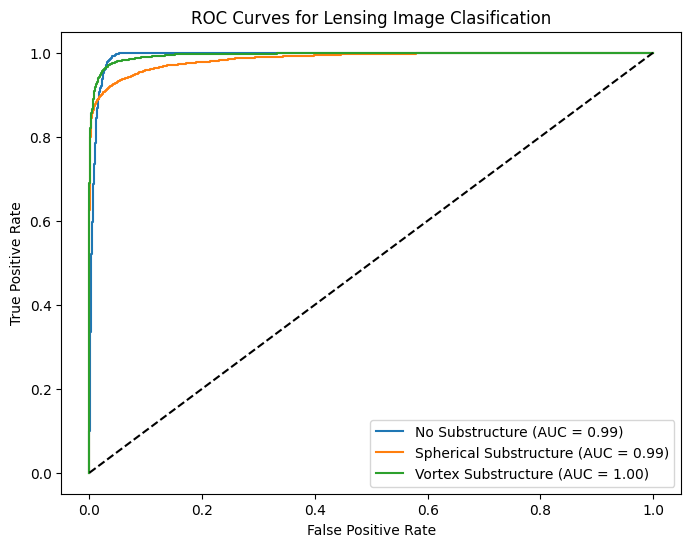

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

def evaluate_and_plot_roc(model, val_dataloader, class_names, device="cuda"):
    """Loads the best saved model and plots ROC curves for all three classes."""
    model.load_state_dict(torch.load("best_test1_model.pth"))
    model.to(device)
    model.eval()

    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()

            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs)

    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    plt.figure(figsize=(8, 6))
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(all_labels == i, all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Lensing Image Clasification')
    plt.legend(loc='lower right')
    plt.show()


class_names = ['No Substructure', 'Spherical Substructure', 'Vortex Substructure']
evaluate_and_plot_roc(model, test_loader, class_names, device="cuda")
